In [1]:
!pip install minisom



  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=e21e02e3fa9e481f910357b2ff36570c466c6464786236efa6cfd71e9ae58ed6
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


In [2]:
!pip install numpy pandas scikit-learn minisom


In [3]:
import pandas as pd

In [4]:
# Load the dataset
url = "https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/combined%20Dataset.csv"
df = pd.read_csv(url)

In [5]:

from sklearn.preprocessing import StandardScaler

# Load dataset
# df = pd.read_csv('dataset.csv')

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Normalize input data
scaler = StandardScaler().fit(X)
X_normalized = scaler.transform(X)

In [6]:
X_normalized

array([[-1.22706109, -1.57352031, -0.8996703 , -1.45136709, -1.16081828],
       [-1.24822802, -0.95877668, -0.71864741, -0.51534311, -1.16094613],
       [-1.20662647, -1.69962042, -0.96369496, -1.74822824, -1.16158793],
       ...,
       [ 0.79134755,  0.6785299 ,  0.08493636,  0.18280126,  0.99384118],
       [ 0.79064123,  0.6730262 ,  0.08512354,  0.18070481,  0.97898514],
       [ 0.79124956,  0.69833078,  0.09167552,  0.19413201,  0.97576335]])

In [16]:
from minisom import MiniSom
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [18]:
# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [19]:
import matplotlib.pyplot as plt


In [20]:
# Initialize and train SOM
som_size = 30  # Example size, adjust based on your dataset
som = MiniSom(som_size, som_size, X_normalized.shape[1], sigma=0.2, learning_rate=0.1, random_seed=42 )
som.train_random(X_normalized, 100)  # training with 100 iterations

# Mapping each input vector to its respective BMU
winner_coordinates = np.array([som.winner(x) for x in X_normalized]).T
# Transforming the SOM's two-dimensional grid to a one-dimensional array
cluster_index = np.ravel_multi_index(winner_coordinates, (som_size, som_size))

# k-NN
knn = KNeighborsClassifier(n_neighbors=3)  # Example k value, adjust based on your dataset
knn.fit(cluster_index.reshape(-1, 1), y)  # Fit using the cluster index as feature

# Example prediction (you can replace X_test with real-time data)
X_test_normalized = X_test  # Assuming X_test is your test set
test_winner_coordinates = np.array([som.winner(x) for x in X_test_normalized]).T
test_cluster_index = np.ravel_multi_index(test_winner_coordinates, (som_size, som_size))
y_pred = knn.predict(test_cluster_index.reshape(-1, 1))




In [21]:
X_test_normalized

array([[-1.08056131, -0.48637193,  2.82261647,  3.09170718, -1.15836614],
       [ 0.86869078,  1.00803465,  0.23315952,  0.3790574 ,  0.86603837],
       [-1.22302465, -1.56048825, -0.88524972, -1.4206586 , -1.1609538 ],
       ...,
       [-1.21176354, -1.0797106 , -0.75093105, -0.69114739, -1.16016113],
       [-1.16687256, -1.08997042, -0.56049599, -0.43632023, -1.16028131],
       [-1.12485401, -0.62913823,  2.7850657 ,  3.1319289 , -1.15956792]])

In [22]:
# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  # Assuming y_test is your test set labels

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       121

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



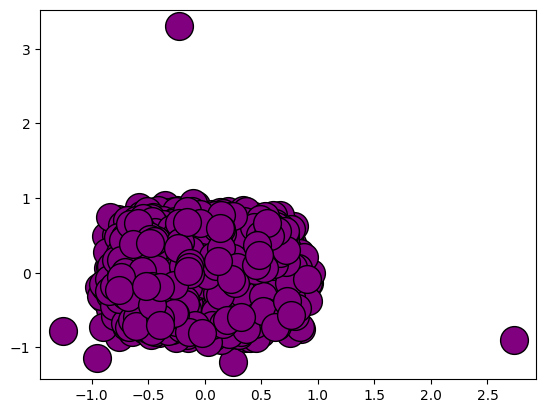

In [23]:
nodes = som.get_weights().reshape(2250, 2)
plt.scatter(nodes[:,0], nodes[:,1], c='purple', s=400, edgecolor='black')
plt.show()

In [24]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameter grids
som_param_grid = {'sigma': [0.1, 0.2, 0.5], 'learning_rate': [0.05, 0.1, 0.2]}
knn_param_grid = {'n_neighbors': [3, 5, 7]}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(som_param_grid))
n_neighbors_values = knn_param_grid['n_neighbors']

for som_params in param_combinations:
    for n_neighbors in n_neighbors_values:
        # Initialize and train SOM
        som = MiniSom(som_size, som_size, X_normalized.shape[1], **som_params, random_seed=42)
        som.train_random(X_normalized, 100)

        # Mapping each input vector to its respective BMU
        winner_coordinates = np.array([som.winner(x) for x in X_normalized]).T
        cluster_index = np.ravel_multi_index(winner_coordinates, (som_size, som_size))

        # Initialize and train k-NN
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(cluster_index.reshape(-1, 1), y)

        # Example prediction (you can replace X_test with real-time data)
        test_winner_coordinates = np.array([som.winner(x) for x in X_test_normalized]).T
        test_cluster_index = np.ravel_multi_index(test_winner_coordinates, (som_size, som_size))
        y_pred = knn.predict(test_cluster_index.reshape(-1, 1))

        # Evaluate performance
        from sklearn.metrics import classification_report
        print(f"SOM Params: {som_params}, k-NN n_neighbors: {n_neighbors}")
        print(classification_report(y_test, y_pred))
        print("=" * 50)


SOM Params: {'learning_rate': 0.05, 'sigma': 0.1}, k-NN n_neighbors: 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       121

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

SOM Params: {'learning_rate': 0.05, 'sigma': 0.1}, k-NN n_neighbors: 5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       121

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

SOM Params: {'learning_rate': 0.05, 'sigma': 0.1}, k-NN n_neighbors: 7
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        95
           1       0.99 

In [25]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameter grids
som_param_grid = {'sigma': [0.1, 0.2, 0.5], 'learning_rate': [0.05, 0.1, 0.2]}
knn_param_grid = {'n_neighbors': [3, 5, 7]}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(som_param_grid))
n_neighbors_values = knn_param_grid['n_neighbors']

for som_params in param_combinations:
    for n_neighbors in n_neighbors_values:
        # Initialize and train SOM
        som = MiniSom(som_size, som_size, X_normalized.shape[1], **som_params, random_seed=42)
        som.train_random(X_normalized, 100)

        # Mapping each input vector to its respective BMU
        winner_coordinates = np.array([som.winner(x) for x in X_normalized]).T
        cluster_index = np.ravel_multi_index(winner_coordinates, (som_size, som_size))

        # Initialize and train k-NN
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(cluster_index.reshape(-1, 1), y)

        # Example prediction (you can replace X_test with real-time data)
        test_winner_coordinates = np.array([som.winner(x) for x in X_test_normalized]).T
        test_cluster_index = np.ravel_multi_index(test_winner_coordinates, (som_size, som_size))
        y_pred = knn.predict(test_cluster_index.reshape(-1, 1))

        # Evaluate performance
        from sklearn.metrics import classification_report
        header = f"SOM Params: {som_params}, k-NN n_neighbors: {n_neighbors}"
        print("=" * len(header))
        print(header)
        print("=" * len(header))
        print(classification_report(y_test, y_pred))
        print("\n" + "=" * len(header) + "\n")


SOM Params: {'learning_rate': 0.05, 'sigma': 0.1}, k-NN n_neighbors: 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       121

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



SOM Params: {'learning_rate': 0.05, 'sigma': 0.1}, k-NN n_neighbors: 5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       121

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



SOM Params: {'learning_rate': 0.05, 'sigma': 0.1}, k-NN n_neighbors: 7
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        95
           1       0

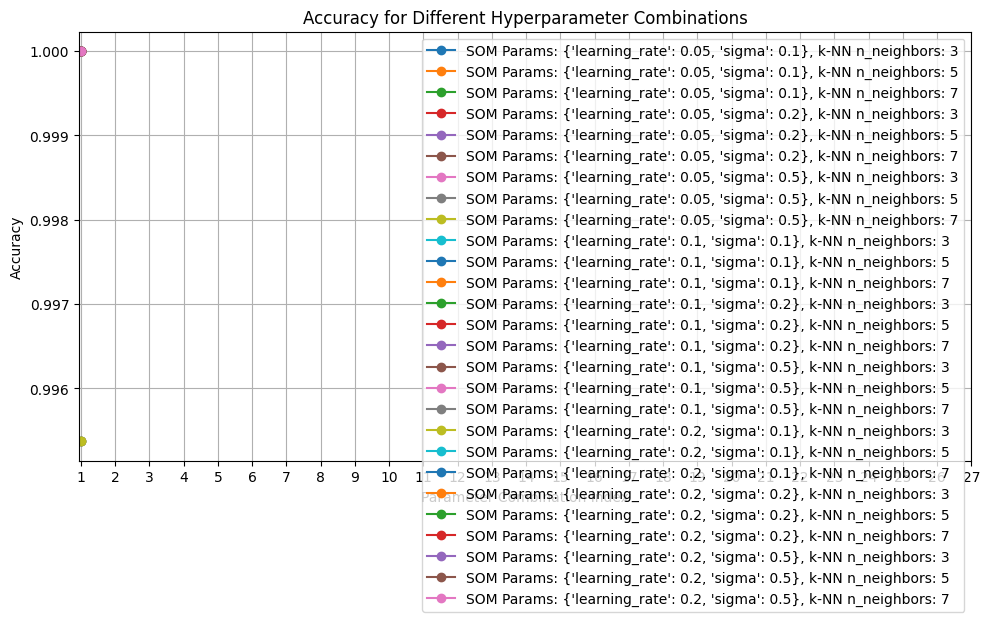

In [26]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

# Define hyperparameter grids
som_param_grid = {'sigma': [0.1, 0.2, 0.5], 'learning_rate': [0.05, 0.1, 0.2]}
knn_param_grid = {'n_neighbors': [3, 5, 7]}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(som_param_grid))
n_neighbors_values = knn_param_grid['n_neighbors']

accuracy_results = []  # Store accuracy results for plotting

for som_params in param_combinations:
    for n_neighbors in n_neighbors_values:
        # Initialize and train SOM
        som = MiniSom(som_size, som_size, X_normalized.shape[1], **som_params, random_seed=42)
        som.train_random(X_normalized, 100)

        # Mapping each input vector to its respective BMU
        winner_coordinates = np.array([som.winner(x) for x in X_normalized]).T
        cluster_index = np.ravel_multi_index(winner_coordinates, (som_size, som_size))

        # Initialize and train k-NN
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(cluster_index.reshape(-1, 1), y)

        # Example prediction (you can replace X_test with real-time data)
        test_winner_coordinates = np.array([som.winner(x) for x in X_test_normalized]).T
        test_cluster_index = np.ravel_multi_index(test_winner_coordinates, (som_size, som_size))
        y_pred = knn.predict(test_cluster_index.reshape(-1, 1))

        # Evaluate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_results.append((som_params, n_neighbors, accuracy))

# Plotting the results
plt.figure(figsize=(10, 6))
for som_params, n_neighbors, accuracy in accuracy_results:
    plt.plot(accuracy, marker='o', label=f"SOM Params: {som_params}, k-NN n_neighbors: {n_neighbors}")

plt.xlabel('Parameter Combination Index')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Hyperparameter Combinations')
plt.xticks(ticks=range(len(accuracy_results)), labels=[f'{i+1}' for i in range(len(accuracy_results))])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
sigma = []
learning_rate = []

# Fill sigma and learning_rate with values ranging from 0.0001 to 1
step_size = 0.01
step_sizes = 0.1
step_sizel = 0.025
current_values = step_size
current_valuel = step_size

while current_values <= 1:
    sigma.append(current_values)

    current_values += step_sizes

while current_valuel <= 1:
    learning_rate.append(current_valuel)
    current_valuel += step_sizel

print(sigma)
print(learning_rate)


[0.01, 0.11, 0.21000000000000002, 0.31000000000000005, 0.41000000000000003, 0.51, 0.61, 0.71, 0.8099999999999999, 0.9099999999999999]
[0.01, 0.035, 0.060000000000000005, 0.085, 0.11000000000000001, 0.135, 0.16, 0.185, 0.21, 0.235, 0.26, 0.28500000000000003, 0.31000000000000005, 0.3350000000000001, 0.3600000000000001, 0.3850000000000001, 0.41000000000000014, 0.43500000000000016, 0.4600000000000002, 0.4850000000000002, 0.5100000000000002, 0.5350000000000003, 0.5600000000000003, 0.5850000000000003, 0.6100000000000003, 0.6350000000000003, 0.6600000000000004, 0.6850000000000004, 0.7100000000000004, 0.7350000000000004, 0.7600000000000005, 0.7850000000000005, 0.8100000000000005, 0.8350000000000005, 0.8600000000000005, 0.8850000000000006, 0.9100000000000006, 0.9350000000000006, 0.9600000000000006, 0.9850000000000007]


In [30]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
# sigma = [0.1, 0.2, 0.5]
# learning_rate = [0.1, 0.2, 0.5]
# Define hyperparameter grids
som_param_grid = {'sigma': sigma, 'learning_rate': learning_rate}
knn_param_grid = {'n_neighbors': [3, 5, 7]}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(som_param_grid))
n_neighbors_values = knn_param_grid['n_neighbors']
maxval123 = len(param_combinations)*len(n_neighbors_values)
print(maxval123)
accuracy_results = []  # Store accuracy results for table display
j=0
for som_params in param_combinations:
    for n_neighbors in n_neighbors_values:
        # Initialize and train SOM
        som = MiniSom(som_size, som_size, X_normalized.shape[1], **som_params, random_seed=42)
        som.train_random(X_normalized, 100)

        # Mapping each input vector to its respective BMU
        winner_coordinates = np.array([som.winner(x) for x in X_normalized]).T
        cluster_index = np.ravel_multi_index(winner_coordinates, (som_size, som_size))

        # k-NN
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(cluster_index.reshape(-1, 1), y)

        # (replace X_test with real-time data)
        test_winner_coordinates = np.array([som.winner(x) for x in X_test_normalized]).T
        test_cluster_index = np.ravel_multi_index(test_winner_coordinates, (som_size, som_size))
        y_pred = knn.predict(test_cluster_index.reshape(-1, 1))

        # Evaluate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_results.append((som_params, n_neighbors, accuracy))
        print(f"{j} of {maxval123}")
        j=j+1

# Create DataFrame for accuracy results
df_accuracy = pd.DataFrame(accuracy_results, columns=['SOM Params', 'k-NN n_neighbors', 'Accuracy'])

# Display the accuracy results table
print(df_accuracy)


1200
0 of 1200
1 of 1200
2 of 1200
3 of 1200
4 of 1200
5 of 1200
6 of 1200
7 of 1200
8 of 1200
9 of 1200
10 of 1200
11 of 1200
12 of 1200
13 of 1200
14 of 1200
15 of 1200
16 of 1200
17 of 1200
18 of 1200
19 of 1200
20 of 1200
21 of 1200
22 of 1200
23 of 1200
24 of 1200
25 of 1200
26 of 1200
27 of 1200
28 of 1200
29 of 1200
30 of 1200
31 of 1200
32 of 1200
33 of 1200
34 of 1200
35 of 1200
36 of 1200
37 of 1200
38 of 1200
39 of 1200
40 of 1200
41 of 1200
42 of 1200
43 of 1200
44 of 1200
45 of 1200
46 of 1200
47 of 1200
48 of 1200
49 of 1200
50 of 1200
51 of 1200
52 of 1200
53 of 1200
54 of 1200
55 of 1200
56 of 1200
57 of 1200
58 of 1200
59 of 1200
60 of 1200
61 of 1200
62 of 1200
63 of 1200
64 of 1200
65 of 1200
66 of 1200
67 of 1200
68 of 1200
69 of 1200
70 of 1200
71 of 1200
72 of 1200
73 of 1200
74 of 1200
75 of 1200
76 of 1200
77 of 1200
78 of 1200
79 of 1200
80 of 1200
81 of 1200
82 of 1200
83 of 1200
84 of 1200
85 of 1200
86 of 1200
87 of 1200
88 of 1200
89 of 1200
90 of 1200
91 o

In [31]:
df_accuracy

,SOM Params,k-NN n_neighbors,Accuracy
0,"{'learning_rate': 0.01, 'sigma': 0.01}",3,1.0
1,"{'learning_rate': 0.01, 'sigma': 0.01}",5,1.0
2,"{'learning_rate': 0.01, 'sigma': 0.01}",7,1.0
3,"{'learning_rate': 0.01, 'sigma': 0.11}",3,1.0
4,"{'learning_rate': 0.01, 'sigma': 0.11}",5,1.0
...,...,...,...
1195,"{'learning_rate': 0.9850000000000007, 'sigma':...",5,1.0
1196,"{'learning_rate': 0.9850000000000007, 'sigma':...",7,1.0
1197,"{'learning_rate': 0.9850000000000007, 'sigma':...",3,1.0
1198,"{'learning_rate': 0.9850000000000007, 'sigma':...",5,1.0


In [54]:
# Initialize and train SOM
som_size = 30  # Example size, adjust based on your dataset
som = MiniSom(som_size, som_size, X_normalized.shape[1], sigma=0.71, learning_rate=0.055,random_seed=42 )
som.train_random(X_normalized, 100)  # training with 100 iterations

# Mapping each input vector to its respective BMU
winner_coordinates = np.array([som.winner(x) for x in X_normalized]).T
# Transforming the SOM's two-dimensional grid to a one-dimensional array
cluster_index = np.ravel_multi_index(winner_coordinates, (som_size, som_size))

# k-NN
knn = KNeighborsClassifier(n_neighbors=3)  # Example k value, adjust based on your dataset
knn.fit(cluster_index.reshape(-1, 1), y)  # Fit using the cluster index as feature

# Example prediction (you can replace X_test with real-time data)
X_test_normalized = scaler.transform(X_test)  # Assuming X_test is your test set
test_winner_coordinates = np.array([som.winner(x) for x in X_test_normalized]).T
test_cluster_index = np.ravel_multi_index(test_winner_coordinates, (som_size, som_size))
y_pred = knn.predict(test_cluster_index.reshape(-1, 1))

# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  # Assuming y_test is your test set labels


              precision    recall  f1-score   support

           0       0.59      0.99      0.74        95
           1       0.98      0.45      0.62       121

    accuracy                           0.69       216
   macro avg       0.78      0.72      0.68       216
weighted avg       0.81      0.69      0.67       216



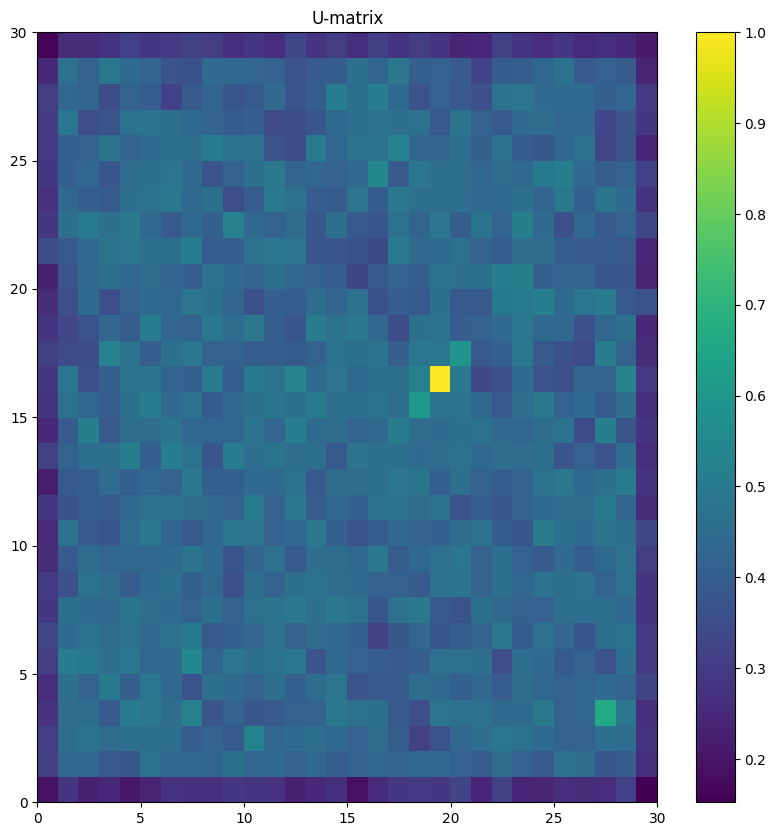

In [55]:
import matplotlib.pyplot as plt

u_matrix = som.distance_map()  # Get the U-matrix

# Plot the U-matrix
plt.figure(figsize=(10, 10))
plt.pcolor(u_matrix, cmap='viridis')  # Use 'viridis' colormap for better visualization
plt.colorbar()
plt.title('U-matrix')
plt.show()

In [60]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Load the dataset
url = "https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/combined%20Dataset.csv"
df = pd.read_csv(url)

X = df[['etpSrcIP', 'etpSrcP', 'etpDstP', 'etpProtocol', 'totalPacket']].values
y = df['label'].values

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Training SOM
# som_size = int(np.sqrt(5 * np.sqrt(X_train.shape[0])))  # heuristic for SOM size
som_size = 30
som = MiniSom(som_size, som_size, X_train.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(X_train, 1000)  # training with 1000 iterations

# Mapping training data to SOM and creating a new dataset with BMU positions
X_train_bmu = np.array([som.winner(x) for x in X_train])
X_test_bmu = np.array([som.winner(x) for x in X_test])

# Define a list of parameter values to try
param_grid = {'n_neighbors': [1, 3, 5]}
knn = KNeighborsClassifier()

# Perform GridSearchCV with k-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_bmu, y_train)

# Get the best model and its performance
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_bmu)

# Print the classification report
report = classification_report(y_test, y_pred)
print("Best Parameters:", best_params)
print("Classification Report:")
print(report)


Best Parameters: {'n_neighbors': 1}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       121

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



In [67]:
from ctypes import sizeof
y_test
y_test.shape()


TypeError: 'tuple' object is not callable

In [65]:
y_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0])

In [61]:
som_size

30

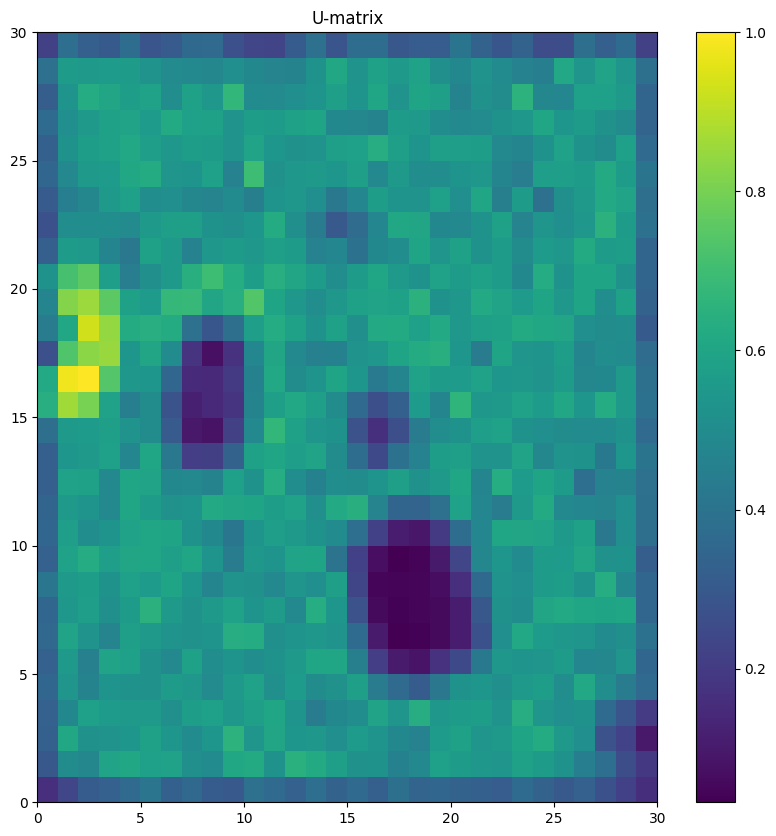

In [62]:
import matplotlib.pyplot as plt

u_matrix = som.distance_map()  # Get the U-matrix

# Plot the U-matrix
plt.figure(figsize=(10, 10))
plt.pcolor(u_matrix, cmap='viridis')  # Use 'viridis' colormap for better visualization
plt.colorbar()
plt.title('U-matrix')
plt.show()

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Load the dataset
url = "https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/combined%20Dataset.csv"
df = pd.read_csv(url)

X = df[['etpSrcIP', 'etpSrcP', 'etpDstP', 'etpProtocol', 'totalPacket']].values
y = df['label'].values

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Training SOM
som_size = int(np.sqrt(5 * np.sqrt(X_train.shape[0])))  # heuristic for SOM size
som = MiniSom(som_size, som_size, X_train.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(X_train, 1000)  # training with 1000 iterations

# Mapping training data to SOM and creating a new dataset with BMU positions
X_train_bmu = np.array([som.winner(x) for x in X_train])
X_test_bmu = np.array([som.winner(x) for x in X_test])

# Define a list of parameter values to try
param_values = [1, 3, 5]

# Store classification reports in a list
reports = []

for param in param_values:
    # SOM + k-NN
    knn = KNeighborsClassifier(n_neighbors=param)
    knn.fit(X_train_bmu, y_train)
    y_pred = knn.predict(X_test_bmu)

    # Evaluate the model
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

# Print the classification reports
for idx, report in enumerate(reports):
    print(f"Classification Report for k={param_values[idx]}:")
    print(pd.DataFrame(report).transpose())
    print("="*50)


Classification Report for k=1:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     95.0
1                   1.0     1.0       1.0    121.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    216.0
weighted avg        1.0     1.0       1.0    216.0
Classification Report for k=3:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     95.0
1                   1.0     1.0       1.0    121.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    216.0
weighted avg        1.0     1.0       1.0    216.0
Classification Report for k=5:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     95.0
1                   1.0     1.0       1.0    121.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    216.0
weighted avg        1.0     1.0       1.

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Load the dataset
url = "https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/combined%20Dataset.csv"
df = pd.read_csv(url)

X = df[['etpSrcIP', 'etpSrcP', 'etpDstP', 'etpProtocol', 'totalPacket']].values
y = df['label'].values

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Training SOM
som_size = int(np.sqrt(5 * np.sqrt(X_train.shape[0])))  # heuristic for SOM size
som = MiniSom(som_size, som_size, X_train.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(X_train, 1000)  # training with 1000 iterations

# Mapping training data to SOM and creating a new dataset with BMU positions
X_train_bmu = np.array([som.winner(x) for x in X_train])
X_test_bmu = np.array([som.winner(x) for x in X_test])

# SOM + k-NN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_bmu, y_train)
y_pred = knn.predict(X_test_bmu)

# Evaluate the model
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       121

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



In [23]:
!pip install numpy pandas sklearn minisom

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [24]:
!pip install minisom

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [26]:
# df = pd.read_csv('/content/combined Dataset.csv')

In [27]:
# Load the dataset
url = "https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/combined%20Dataset.csv"
df = pd.read_csv(url)
df.shape

(718, 6)

In [28]:
# Display the first few rows of the dataset
print("Dataset loaded successfully. First few rows:")
print(df.head())



Dataset loaded successfully. First few rows:
   etpSrcIP   etpSrcP   etpDstP  etpProtocol  totalPacket  label
0  2.536088  0.068600  0.046527     0.055703         1724      0
1  2.437283  0.403030  0.178079     0.231339         1674      0
2  2.631475  0.000000  0.000000     0.000000         1423      0
3  2.930899  0.744501  0.761118     0.507351         1867      0
4  4.449604  0.735550  3.596202     0.999931         2973      0


In [29]:
# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())




Checking for missing values:
etpSrcIP       0
etpSrcP        0
etpDstP        0
etpProtocol    0
totalPacket    0
label          0
dtype: int64


In [30]:
# Assuming the dataset has the necessary columns based on the paper's description
# Features: 'etpSrcIP', 'etpSrcP', 'etpDstP', 'etpProtocol', 'totalPacket'
# Label: 'isAttack'
X = df[['etpSrcIP', 'etpSrcP', 'etpDstP', 'etpProtocol', 'totalPacket']].values


In [31]:
X

array([[2.53608822e+00, 6.86003391e-02, 4.65273996e-02, 5.57031010e-02,
        1.72400000e+03],
       [2.43728318e+00, 4.03030036e-01, 1.78078641e-01, 2.31338872e-01,
        1.67400000e+03],
       [2.63147488e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.42300000e+03],
       ...,
       [1.19578097e+01, 1.29374921e+00, 7.62051451e-01, 3.62338854e-01,
        8.44383000e+05],
       [1.19545126e+01, 1.29075512e+00, 7.62187480e-01, 3.61945476e-01,
        8.38573000e+05],
       [1.19573523e+01, 1.30452119e+00, 7.66948870e-01, 3.64464960e-01,
        8.37313000e+05]])

In [32]:
y = df['label'].values

In [33]:
print(X.shape)
print(y.shape)

(718, 5)
(718,)


In [34]:
# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
X_scaled

array([[-1.22706109, -1.57352031, -0.8996703 , -1.45136709, -1.16081828],
       [-1.24822802, -0.95877668, -0.71864741, -0.51534311, -1.16094613],
       [-1.20662647, -1.69962042, -0.96369496, -1.74822824, -1.16158793],
       ...,
       [ 0.79134755,  0.6785299 ,  0.08493636,  0.18280126,  0.99384118],
       [ 0.79064123,  0.6730262 ,  0.08512354,  0.18070481,  0.97898514],
       [ 0.79124956,  0.69833078,  0.09167552,  0.19413201,  0.97576335]])

In [36]:
# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [37]:
# Training SOM
som_size = int(np.sqrt(5*np.sqrt(X_train.shape[0])))  # heuristic for SOM size



In [38]:
som_size

10

In [39]:
som = MiniSom(som_size, som_size, X_train.shape[1], sigma=1.0, learning_rate=0.5)


In [40]:
som

In [41]:
som.train_random(X_train, 1000)  # training with 1000 iterations

In [42]:
# Mapping training data to SOM and creating a new dataset with BMU positions
X_train_bmu = np.array([som.winner(x) for x in X_train])
X_test_bmu = np.array([som.winner(x) for x in X_test])


In [43]:
# SOM + k-NN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_bmu, y_train)
score = knn.score(X_test_bmu, y_test)


In [44]:
print(f'Accuracy of SOM + k-NN: {score*100:.2f}%')

Accuracy of SOM + k-NN: 100.00%
